## Интеллектуальный анализ данных – весна 2023
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.plotting import plot_decision_regions

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

In [3]:
X.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

### ПРИМЕР ВЫВОДА ###
NN 	 Train 	 Test
1 	 1.0 	 0.56
3 	 0.83 	 0.61
5 	 0.81 	 0.63
10 	 0.79 	 0.54
15 	 0.74 	 0.57
25 	 0.76 	 0.56


In [7]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_train_pd = pd.DataFrame(data=X_train_norm)
X_train_pd.columns = list(X.columns.values )

In [8]:
X_test_norm = scaler.transform(X_test)
X_test_pd = pd.DataFrame(data=X_test_norm)
X_test_pd.columns = list(X.columns.values )

In [9]:
N = [1, 3, 5, 10, 15, 25]
classificators = []
df = pd.DataFrame(columns=['NN', 'train', 'test'])
for i in N:
    neigh = KNeighborsClassifier(n_neighbors=i, metric = 'minkowski', p = 2)
    neigh.fit(X_train_pd[['alcohol', 'magnesium']], y_train)
    classificators.append(neigh)
    df.loc[ len(df.index )] = [i,neigh.score(X_train_pd[['alcohol', 'magnesium']], y_train, sample_weight=None),neigh.score(X_test_pd[['alcohol', 'magnesium']], y_test, sample_weight=None)]
df

,NN,train,test
0,1.0,0.991935,0.666667
1,3.0,0.838710,0.648148
2,5.0,0.806452,0.685185
3,10.0,0.806452,0.703704
4,15.0,0.782258,0.685185
5,25.0,0.725806,0.685185


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/). 

In [10]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [11]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

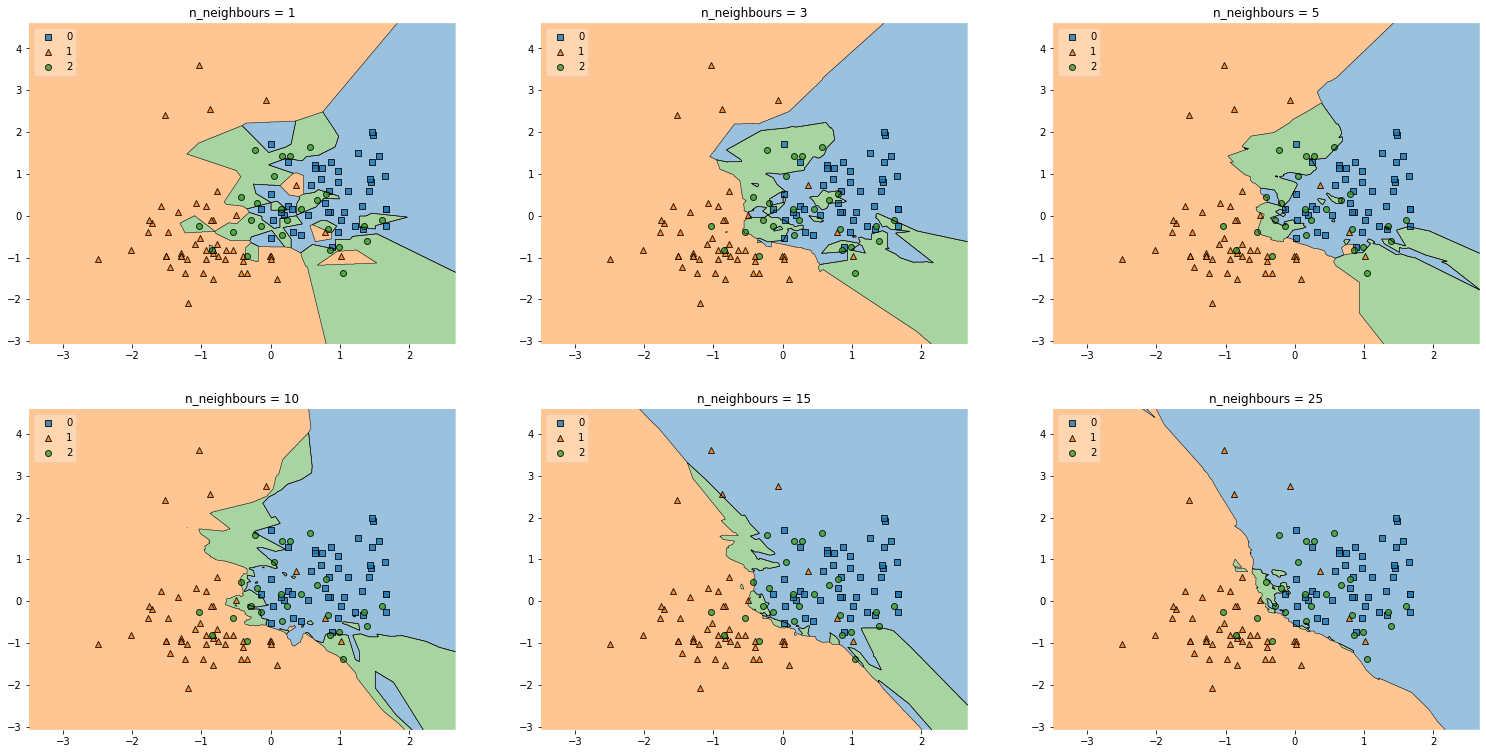

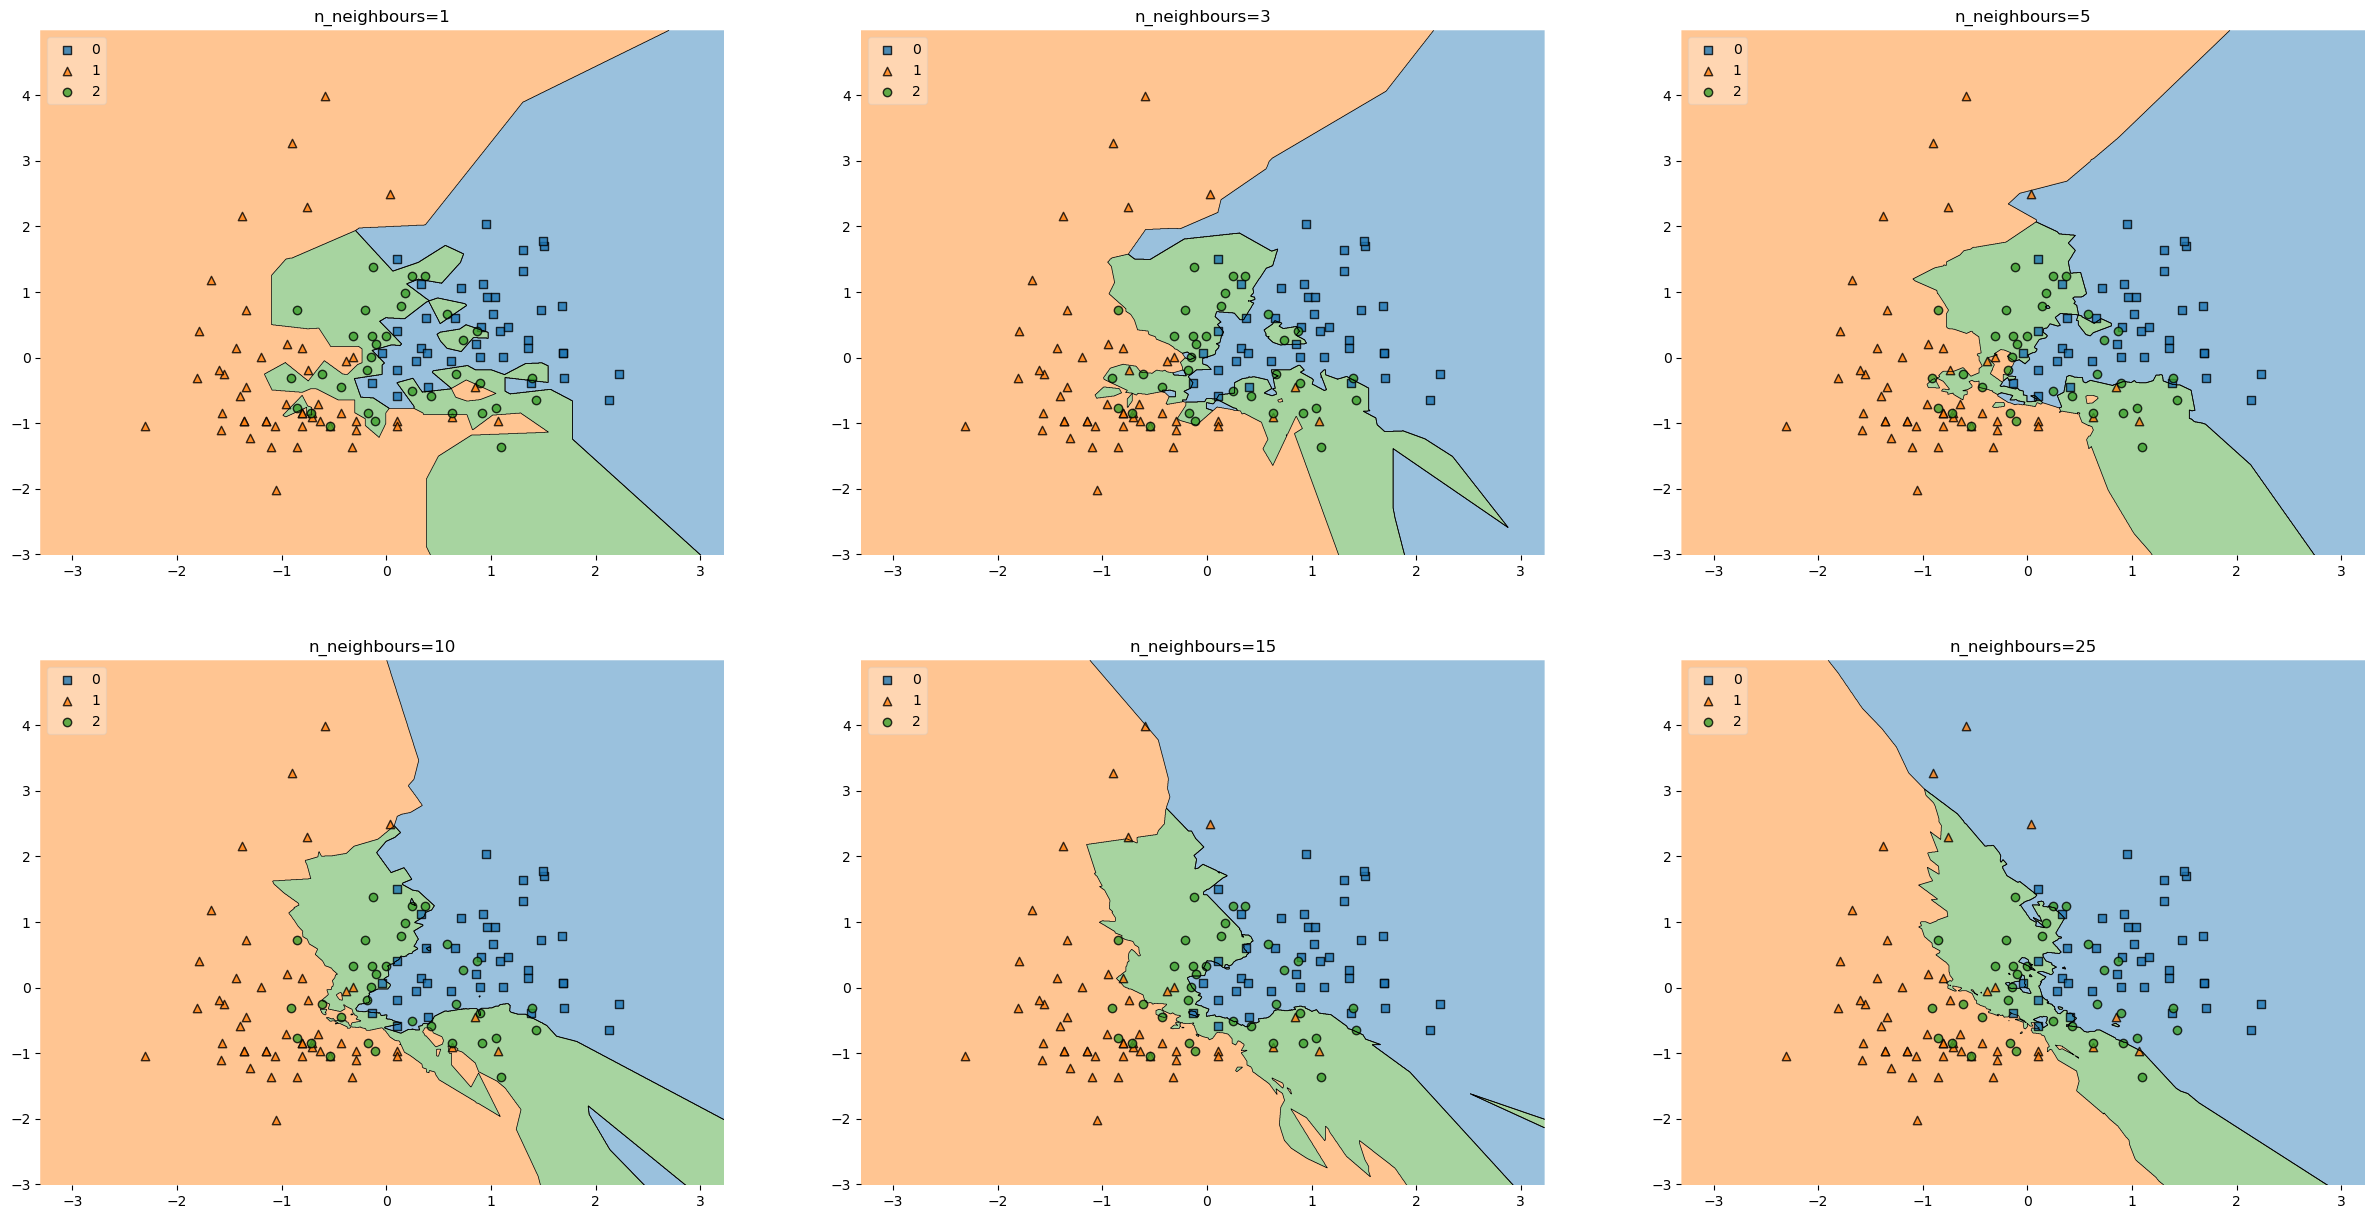

In [200]:
gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(30, 15))

labels = ['n_neighbours='+str(i) for i in N]
for clf, lab, grd in zip(classificators,
                         labels,
                         itertools.product([0, 1, 2], repeat=2)):

    clf.fit(X_train_pd[['alcohol', 'magnesium']], y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=np.array(X_train_pd[['alcohol', 'magnesium']]), y=y_train, clf=clf, legend=2)
    plt.title(lab)

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

Оптимальное значение количества соседей это 5-10, потому что если брать к меньше, то области становятся очень резкими и разбиты на кусочки. При большем к синяя область начинает вытесянять остальное, что не есть хорошо.

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

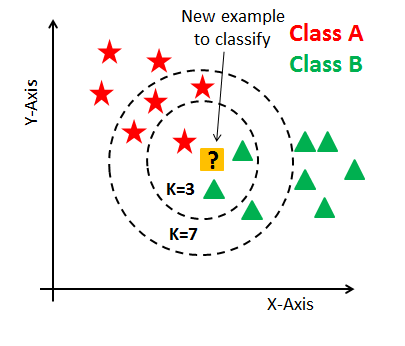

In [12]:
import numpy as np
from collections import Counter 
import statistics as st

class KNN:
    def __init__(self, k:int):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y    
    
    def predict(self, X):
        a = []
        for i in X:
            self.len = ((self.X_train - i)*(self.X_train - i)).sum(axis = 1)
            self.ind = np.argpartition(self.len, self.k)[:self.k]
            a.append(st.mode(self.y_train[self.ind]))
        return np.asarray(a)

In [13]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [14]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [15]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [16]:
data.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [17]:
data.drop (columns=data.columns [0], axis= 1 , inplace= True )
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [18]:
data.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


Больше всего с `price` корреляируют факторы отражающие размры алмаза: `x`, `y` и `z`. Для них $Corr_{Pearson} > 0.8$. 

In [19]:
from scipy.stats.stats import pearsonr
pearsonr(data['price'], data['depth'])

PearsonRResult(statistic=-0.01064740458414299, pvalue=0.013403249011863443)

Как видим, коэффициент корреляции между `depth` и `price` является статистически не значимым для уровня значимости $\alpha = 0.05$ ($p-value < \alpha$)

**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [20]:
X_dum = pd.get_dummies(data, drop_first=True)
X_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   carat          53940 non-null  float64
 1   depth          53940 non-null  float64
 2   table          53940 non-null  float64
 3   price          53940 non-null  int64  
 4   x              53940 non-null  float64
 5   y              53940 non-null  float64
 6   z              53940 non-null  float64
 7   cut_Good       53940 non-null  uint8  
 8   cut_Ideal      53940 non-null  uint8  
 9   cut_Premium    53940 non-null  uint8  
 10  cut_Very Good  53940 non-null  uint8  
 11  color_E        53940 non-null  uint8  
 12  color_F        53940 non-null  uint8  
 13  color_G        53940 non-null  uint8  
 14  color_H        53940 non-null  uint8  
 15  color_I        53940 non-null  uint8  
 16  color_J        53940 non-null  uint8  
 17  clarity_IF     53940 non-null  uint8  
 18  clarit

**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [21]:
X = X_dum.drop(labels='price', axis=1, inplace=False)
y = X_dum['price']
X.head(8)

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,3.95,3.98,2.43,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,3.89,3.84,2.31,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,4.05,4.07,2.31,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,4.20,4.23,2.63,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,4.34,4.35,2.75,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
5,0.24,62.8,57.0,3.94,3.96,2.48,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
6,0.24,62.3,57.0,3.95,3.98,2.47,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
7,0.26,61.9,55.0,4.07,4.11,2.53,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [23]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_train_pd = pd.DataFrame(data=X_train_norm)
X_train_pd.columns = list(X.columns.values )

In [24]:
X_test_norm = scaler.transform(X_test)
X_test_pd = pd.DataFrame(data=X_test_norm)
X_test_pd.columns = list(X.columns.values )

**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [25]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

In [26]:
lr = LinearRegression().fit(X_train_pd, y_train)

print(f"Train: {mean_squared_error(y_train, lr.predict(X_train_pd))}")
print(f"Test: {mean_squared_error(y_test, lr.predict(X_test_pd))}")

Train: 1284661.8621191254
Test: 1259159.1137946637


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [27]:
lr.coef_

array([ 5.27811998e+03, -9.42669361e+01, -6.56183723e+01, -1.05002476e+03,
       -2.64737971e+00, -4.05686230e+01,  1.55923708e+02,  3.89952109e+02,
        3.14449843e+02,  2.91047679e+02, -6.95800253e+01, -9.09479485e+01,
       -1.82693620e+02, -3.39522613e+02, -4.30763476e+02, -5.17728075e+02,
        9.57549314e+02,  1.57320442e+03,  1.01623724e+03,  1.64046365e+03,
        1.79084281e+03,  1.26334765e+03,  1.44548292e+03])

На порядок превышает коэффициент при переменной `carat`, различными `clarity` и `x`. Они приблизительно равен $10^3$, в то время как остальные $10^2$ и меньше

**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [28]:
lasso = Lasso(10.0).fit(X_train_pd, y_train)
print("Lasso")
lasso.coef_

Lasso


array([4784.58223808, -100.46417419,  -76.80709351, -603.5249138 ,
         -0.        ,  -40.09153589,   32.15914057,  184.43593078,
        128.3877937 ,  120.81319164,   -0.        ,  -24.42703051,
       -105.82444228, -267.91959723, -359.19659407, -459.60473492,
        655.3063347 ,  869.81778569,  406.58029782, 1046.99977323,
       1103.88044864,  846.4660105 ,  963.06160789])

In [29]:
ridge = Ridge(10).fit(X_train_pd, y_train)
print("Ridge")
ridge.coef_

Ridge


array([ 5.24003259e+03, -9.24621010e+01, -6.57910975e+01, -1.00868974e+03,
       -4.49021066e+00, -4.40571340e+01,  1.56659289e+02,  3.91313955e+02,
        3.15641410e+02,  2.92535205e+02, -6.91760923e+01, -9.07485383e+01,
       -1.82171492e+02, -3.38702374e+02, -4.29443100e+02, -5.16473294e+02,
        9.45726951e+02,  1.54418240e+03,  9.91592270e+02,  1.61635507e+03,
        1.76271375e+03,  1.24679513e+03,  1.42605709e+03])

Для `Lasso` регрессии коэффициенты очень сильно изменились, часть из них стала практически равна нулю. Для `Ridge` регрессии тоже наблюдаются сильные изменения коэффициентов. Регуляризация сильно изменила наши коэффиценты, что говорит о присутствии высокой мультиколлениарности в модели, что было понятно после построяния матрицы корреляций.

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

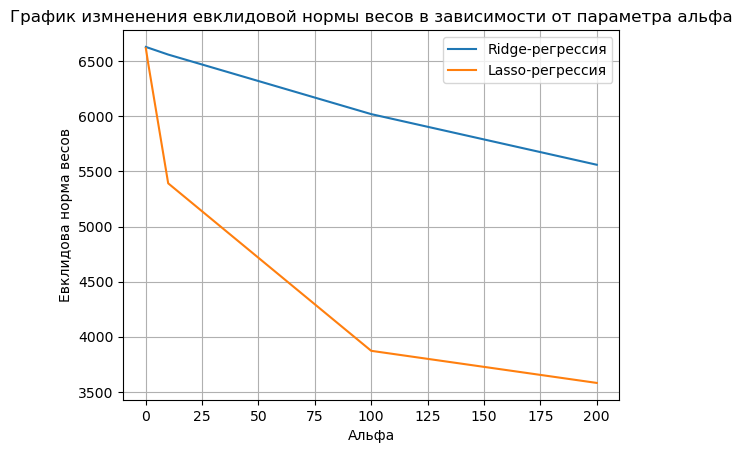

In [30]:
a = [0.1, 1, 10, 100, 200]
L=[]
R=[]
for i in a:
    ridge = Ridge(i).fit(X_train_pd, y_train)
    R.append(np.linalg.norm(ridge.coef_))
    lasso = Lasso(i).fit(X_train_pd, y_train)
    L.append(np.linalg.norm(lasso.coef_))
    
plt.plot(a, R, label = "Ridge-регрессия")
plt.plot(a, L, label = "Lasso-регрессия")
plt.title('График измненения евклидовой нормы весов в зависимости от параметра альфа')
plt.xlabel('Альфа', fontsize=10)
plt.ylabel('Евклидова норма весов', fontsize=10)
plt.grid(True)
plt.legend()
plt.show()

Агрессивнее уменьшает веса Lasso регрессия, потому что значение евклидовой нормы весов меньше для всех $\alpha$. Таким образом, Lasso регрессия помогает понять какие параметры регрессии можно убрать из модели.

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [31]:
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=5, random_state=0, alphas = a).fit(X_train_pd, y_train)
df = pd.DataFrame(reg.mse_path_)
df['alpha'] = reg.alphas_
df

,0,1,2,3,4,alpha
0,2.289042e+06,2.083690e+06,2.255249e+06,2.051188e+06,2.157988e+06,200.0
1,1.901481e+06,1.721242e+06,1.858020e+06,1.678567e+06,1.801532e+06,100.0
2,1.441419e+06,1.299342e+06,1.383143e+06,1.261209e+06,1.345867e+06,10.0
3,1.378931e+06,1.242353e+06,1.334006e+06,1.212486e+06,1.273524e+06,1.0
4,1.377858e+06,1.241614e+06,1.334506e+06,1.239812e+06,1.272007e+06,0.1


In [32]:
df1 = pd.DataFrame(columns = reg.alphas_)
df1.loc[0] = np.array(df[[0,1,2,3,4]].mean(axis=1))
df1

,200.0,100.0,10.0,1.0,0.1
0,2.167432e+06,1.792168e+06,1.346196e+06,1.288260e+06,1.293159e+06


Выбираем $\alpha=0.1$

**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37758 entries, 16259 to 2732
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   carat          37758 non-null  float64
 1   depth          37758 non-null  float64
 2   table          37758 non-null  float64
 3   x              37758 non-null  float64
 4   y              37758 non-null  float64
 5   z              37758 non-null  float64
 6   cut_Good       37758 non-null  uint8  
 7   cut_Ideal      37758 non-null  uint8  
 8   cut_Premium    37758 non-null  uint8  
 9   cut_Very Good  37758 non-null  uint8  
 10  color_E        37758 non-null  uint8  
 11  color_F        37758 non-null  uint8  
 12  color_G        37758 non-null  uint8  
 13  color_H        37758 non-null  uint8  
 14  color_I        37758 non-null  uint8  
 15  color_J        37758 non-null  uint8  
 16  clarity_IF     37758 non-null  uint8  
 17  clarity_SI1    37758 non-null  uint8  
 18  cla

In [35]:
lasso = Lasso(1).fit(X_train_pd, y_train)
lasso.coef_

array([ 5228.56086133,   -94.81899154,   -66.71608979, -1007.19846437,
          -0.        ,   -40.84217731,   143.62017829,   369.55250696,
         295.99492832,   274.12993973,   -62.50195326,   -84.22618828,
        -174.9291816 ,  -332.2982653 ,  -423.54470024,  -511.86764625,
         926.94240145,  1501.97936613,   954.50436151,  1580.37352146,
        1721.28955256,  1221.13867319,  1396.64080979])

Наоиболее информативными оказались признаки `carat` (что отражает зависимость между весом алмаза и ценой), очень информативными оказались параметры `clarity`, что говорит о том, что чем "чище" алмаз, тем он дороже, что логично. Параметры `y`и `z` оказались маленькими по сравнению с остальными, потому что вес (`carat`) и `x`сильно коррелируют с {y, z}. Цвет алмаза оказался менее значимым.

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [37]:
print('simple LinReg')
lr = LinearRegression().fit(X_train_pd, y_train)
print(f"Test: {mean_squared_error(y_test, lr.predict(X_test_pd))}")

print('Lasso')
lasso = Lasso(0.1).fit(X_train_pd, y_train)
print(f"Test: {mean_squared_error(y_test, lasso.predict(X_test_pd))}")

simple LinReg
Test: 1259159.1137946637
Lasso
Test: 1259320.0489129242


По качеству (если мерить в MSE) модели оказались очень сильно похожи. Сказать точно какая лучше нельзя, потому что если поменять чуть-чуть сид (при смене сида может поменяться и альфа: колебляться между 1 и 0.1) MSE одной модели станет больше другой и наоборот.